In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import spearmanr
import seaborn as sns

data_file_path = r"C:\Users\govertsen.k\Northeastern University\Community Resilience in Extreme Temperatures - Data\Vulnerability Mapping"
data_file_path = data_file_path.replace(os.sep, '/')

# Constants
labelfont = {'fontname':'Calibri'}
ticksize = 10
labelsize = 12
subtitlesize = 14
titlesize = 18
hot_T = 80
min_D = 0

# Conversion Functions 
def F_to_C(F):
    C = (F - 32)*5/9
    return C

def C_to_F(C):
    F = C*9/5 + 32
    return F

In [2]:
years = os.listdir(data_file_path + "/ERP/Data")
outages = pd.DataFrame()
for each_year in years: 
    # list to store files
    files = []
    # Iterate directory
    for file in os.listdir(data_file_path + "/ERP/Data/" + each_year):
        # check only text files
        if file.endswith('.csv'):
            files.append(file)
    for each_file in files:
        outage_file = pd.read_csv(data_file_path + "/ERP/Data/" + each_year + "/" + each_file)
        outages = pd.concat([outages,outage_file])
outages = outages.reset_index(drop = True)
outages['Date and Time In'] = pd.to_datetime(outages['Date and Time In'])
outages['Date and Time Out'] = pd.to_datetime(outages['Date and Time Out'])
outages['DATE'] = outages['Date and Time In'].dt.date

In [3]:
weather = pd.read_csv(data_file_path + '/Weather Files/USW00094746.csv',low_memory=False)
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather['DATE'] = weather['DATE'].dt.date

In [4]:
#reduce weather to same date as outages
weather = weather.loc[(weather['DATE'] >= min(outages['Date and Time In'])) & (weather['DATE'] <= max(outages['Date and Time Out']))] 
weather = weather.reset_index(drop = True)

C:\Users\govertsen.k\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [5]:
outages['TMAX'] = outages['DATE'].map(weather.set_index('DATE')['TMAX'])
outages = outages.dropna(subset=['TMAX'])

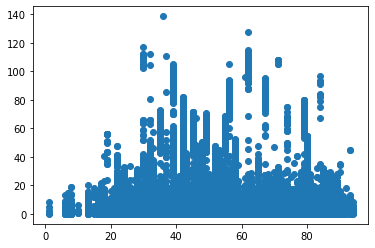

In [6]:
plt.scatter(outages['TMAX'],outages['Actual Duration'])

(0.0, 5.0)

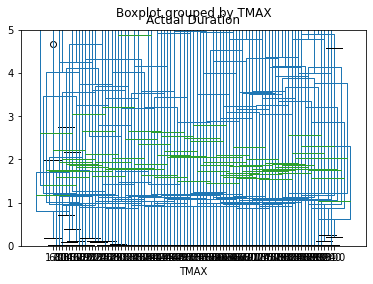

In [7]:
outages.boxplot(by='TMAX',column='Actual Duration',grid=False,widths=10)
plt.ylim([0,5])

In [8]:
summary = pd.DataFrame()
summary.index = outages['TMAX'].unique()
summary['5%'] = 0 
summary['25%'] = 0 
summary['50%'] = 0 
summary['75%'] = 0 
summary['95%'] = 0 

for each_t in summary.index:
    sample = outages.loc[outages['TMAX'] == each_t]
    summary.loc[summary.index == each_t,'5%'] = sample['Actual Duration'].quantile(q=.05)
    summary.loc[summary.index == each_t,'25%'] = sample['Actual Duration'].quantile(q=.25)
    summary.loc[summary.index == each_t,'50%'] = sample['Actual Duration'].quantile(q=.5)
    summary.loc[summary.index == each_t,'75%'] = sample['Actual Duration'].quantile(q=.75)
    summary.loc[summary.index == each_t,'95%'] = sample['Actual Duration'].quantile(q=.95)
summary = summary.dropna()
summary = summary.sort_index()


In [9]:
summary

,5%,25%,50%,75%,95%
1.0,0.3100,0.8150,1.185,1.7050,5.6150
6.0,0.0300,1.3975,2.615,5.5325,8.5365
7.0,0.0900,1.2275,1.410,3.4700,9.6925
8.0,0.2365,1.0250,1.765,4.0200,11.0440
10.0,0.7450,0.9750,1.740,2.0575,4.8590
...,...,...,...,...,...
90.0,0.4060,1.0700,1.780,3.2150,6.9210
91.0,0.4740,0.9700,1.760,4.1500,7.4360
92.0,0.3480,0.8800,1.580,2.8700,5.0150
93.0,0.4610,1.2200,2.040,3.7700,7.5790


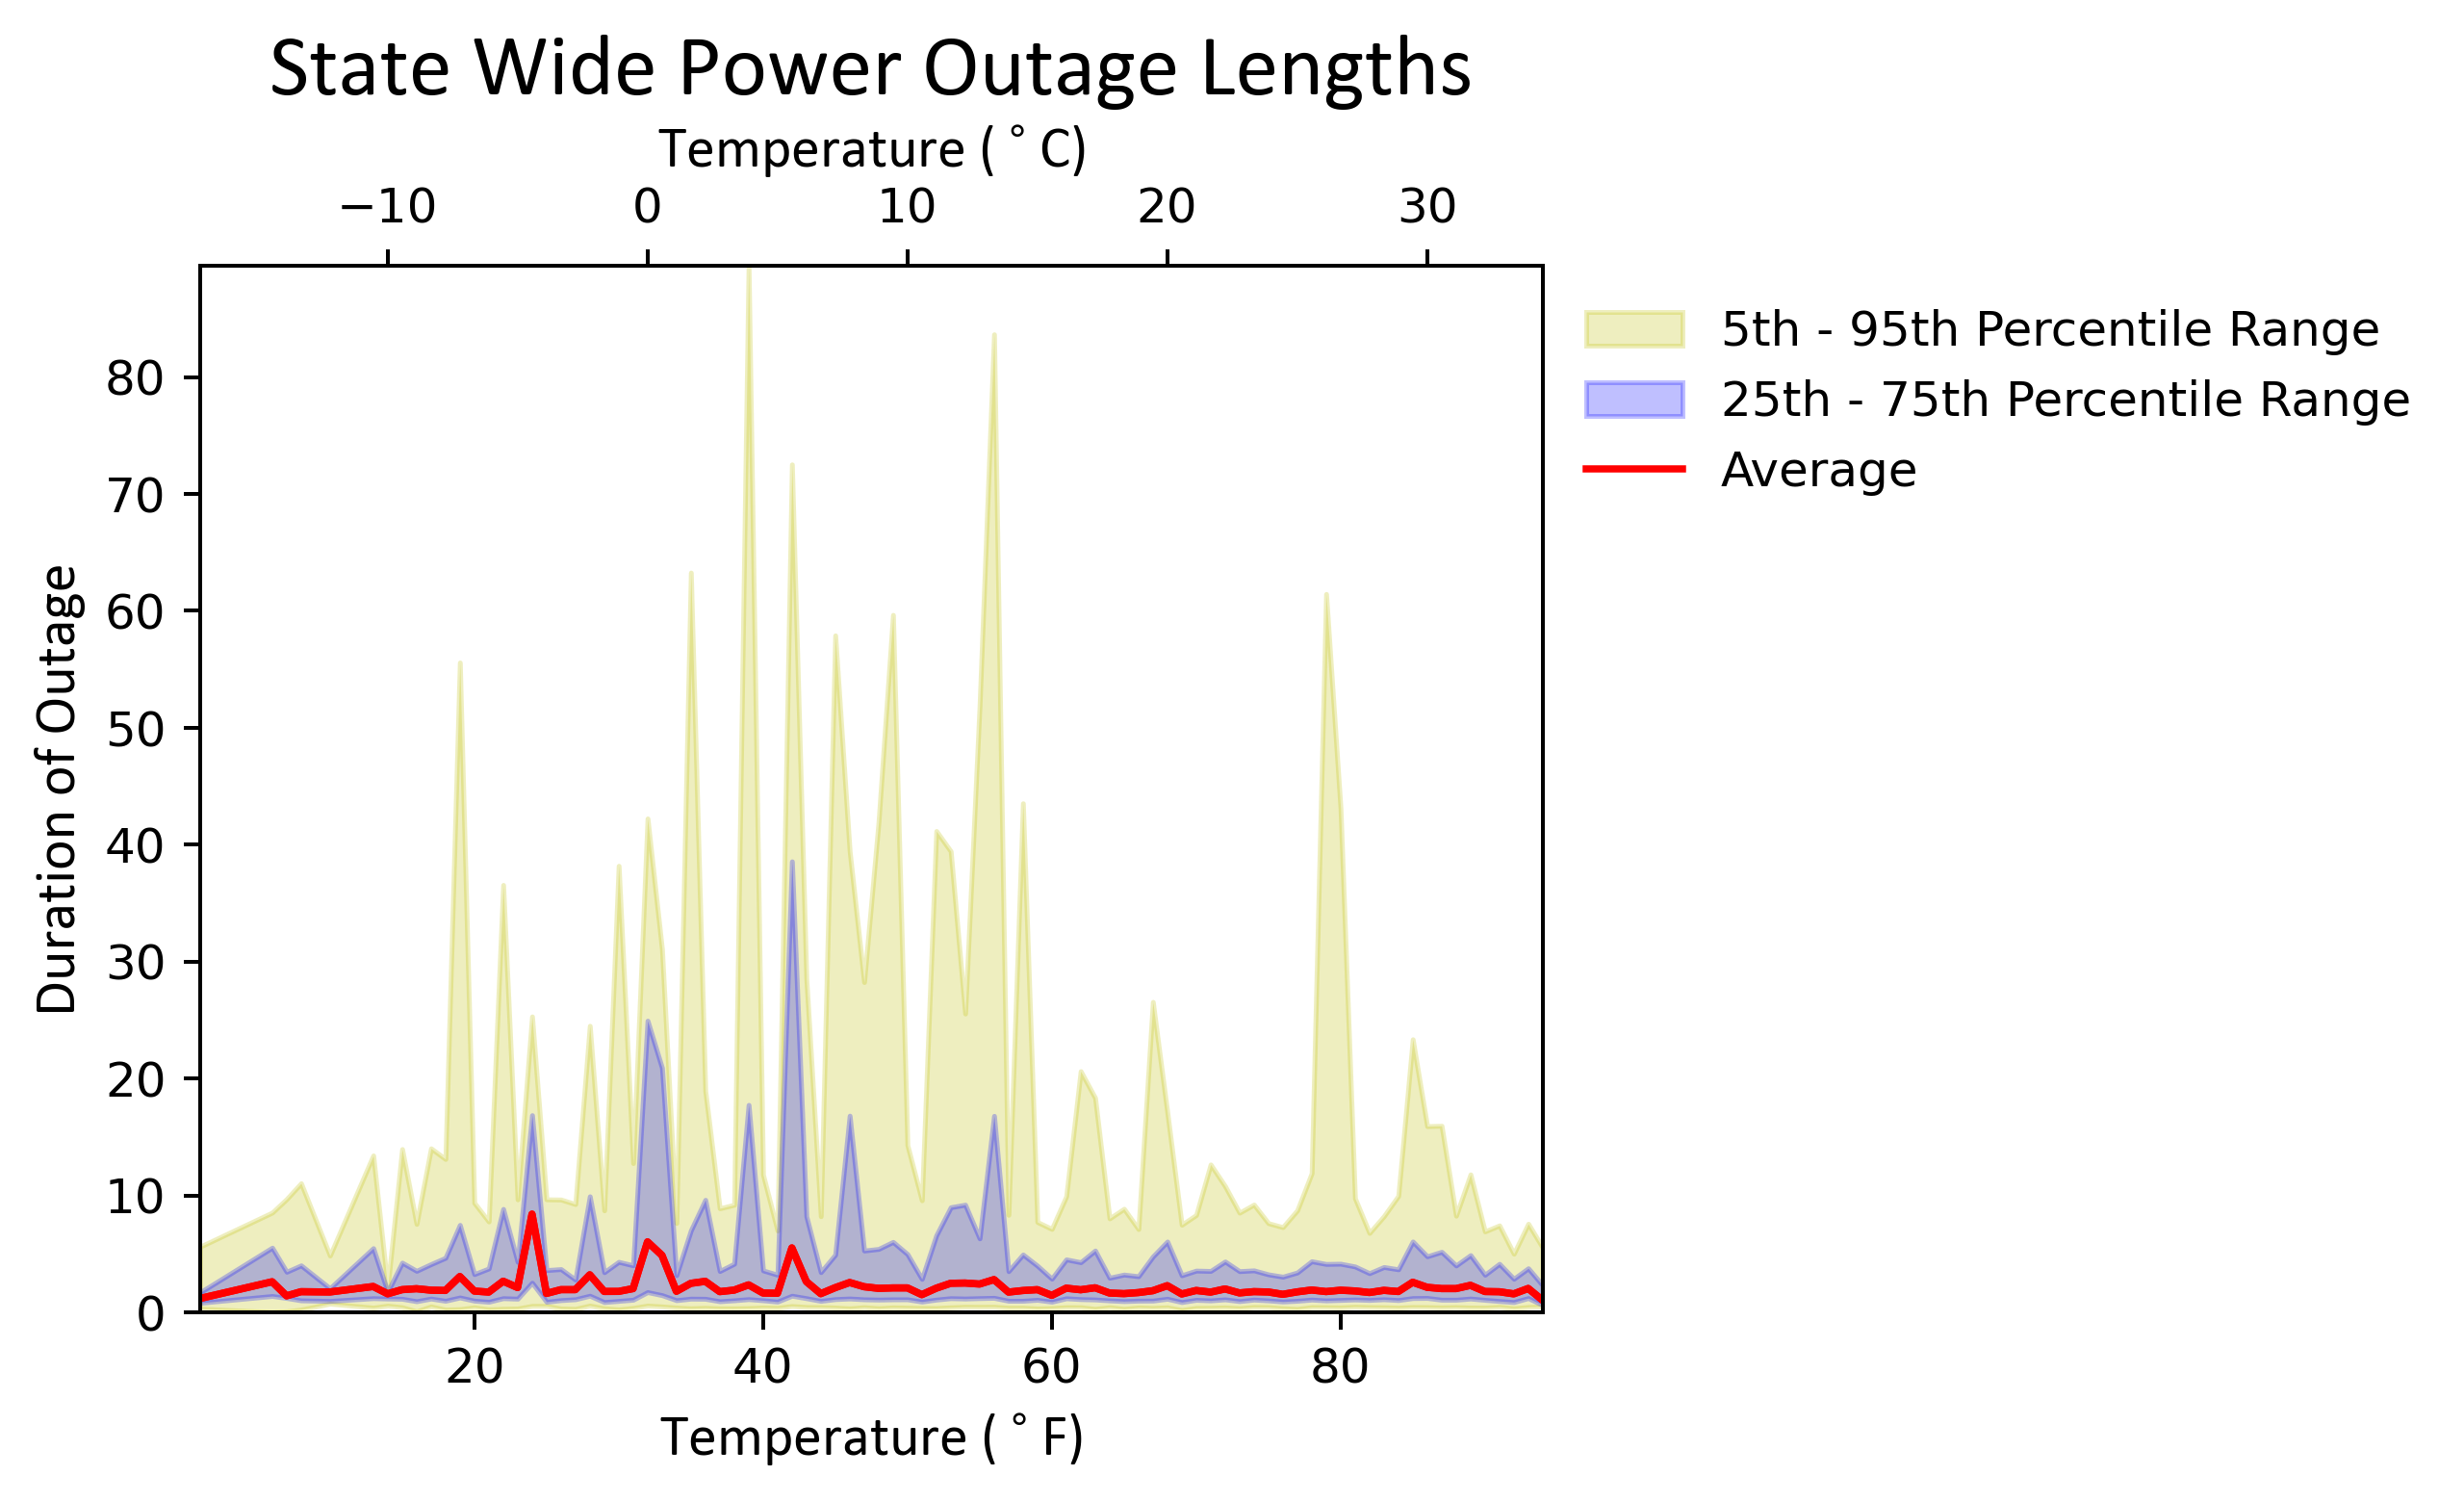

In [10]:
f1, ax1 = plt.subplots(figsize=(5,4),dpi=360)
ax1.fill_between(summary.index, summary['5%'], summary['95%'],alpha=.25,color='y',label="5th - 95th Percentile Range")
ax1.fill_between(summary.index, summary['25%'], summary['75%'],alpha=.25,color='b',label="25th - 75th Percentile Range")
ax1.plot(summary.index,summary['50%'],color='r',label="Average")
ax1.set_ylabel('Duration of Outage',fontsize=labelsize,**labelfont)
ax1.set_xlabel('Temperature ($^\circ$F)',fontsize=labelsize,**labelfont)
ax1b=ax1.twiny()
ax1b.plot(F_to_C(summary.index),summary['50%'],color='r',label="Average")
ax1b.set_xlabel('Temperature ($^\circ$C)',fontsize=labelsize,**labelfont)
ax1.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left',frameon=False)
ax1.set_xlim([min(summary.index),max(summary.index)])
ax1b.set_xlim([F_to_C(min(summary.index)),F_to_C(max(summary.index))])
ax1.set_ylim([min_D,max(summary['95%'])])
ax1.set_title('State Wide Power Outage Lengths',fontsize=titlesize,**labelfont)
f1.savefig(data_file_path + "/ERP/figures/"+"State_POL_Zoom_0.svg",bbox_inches = "tight")
f1.savefig(data_file_path + "/ERP/figures/"+"State_POL_Zoom_0.png",bbox_inches = "tight")

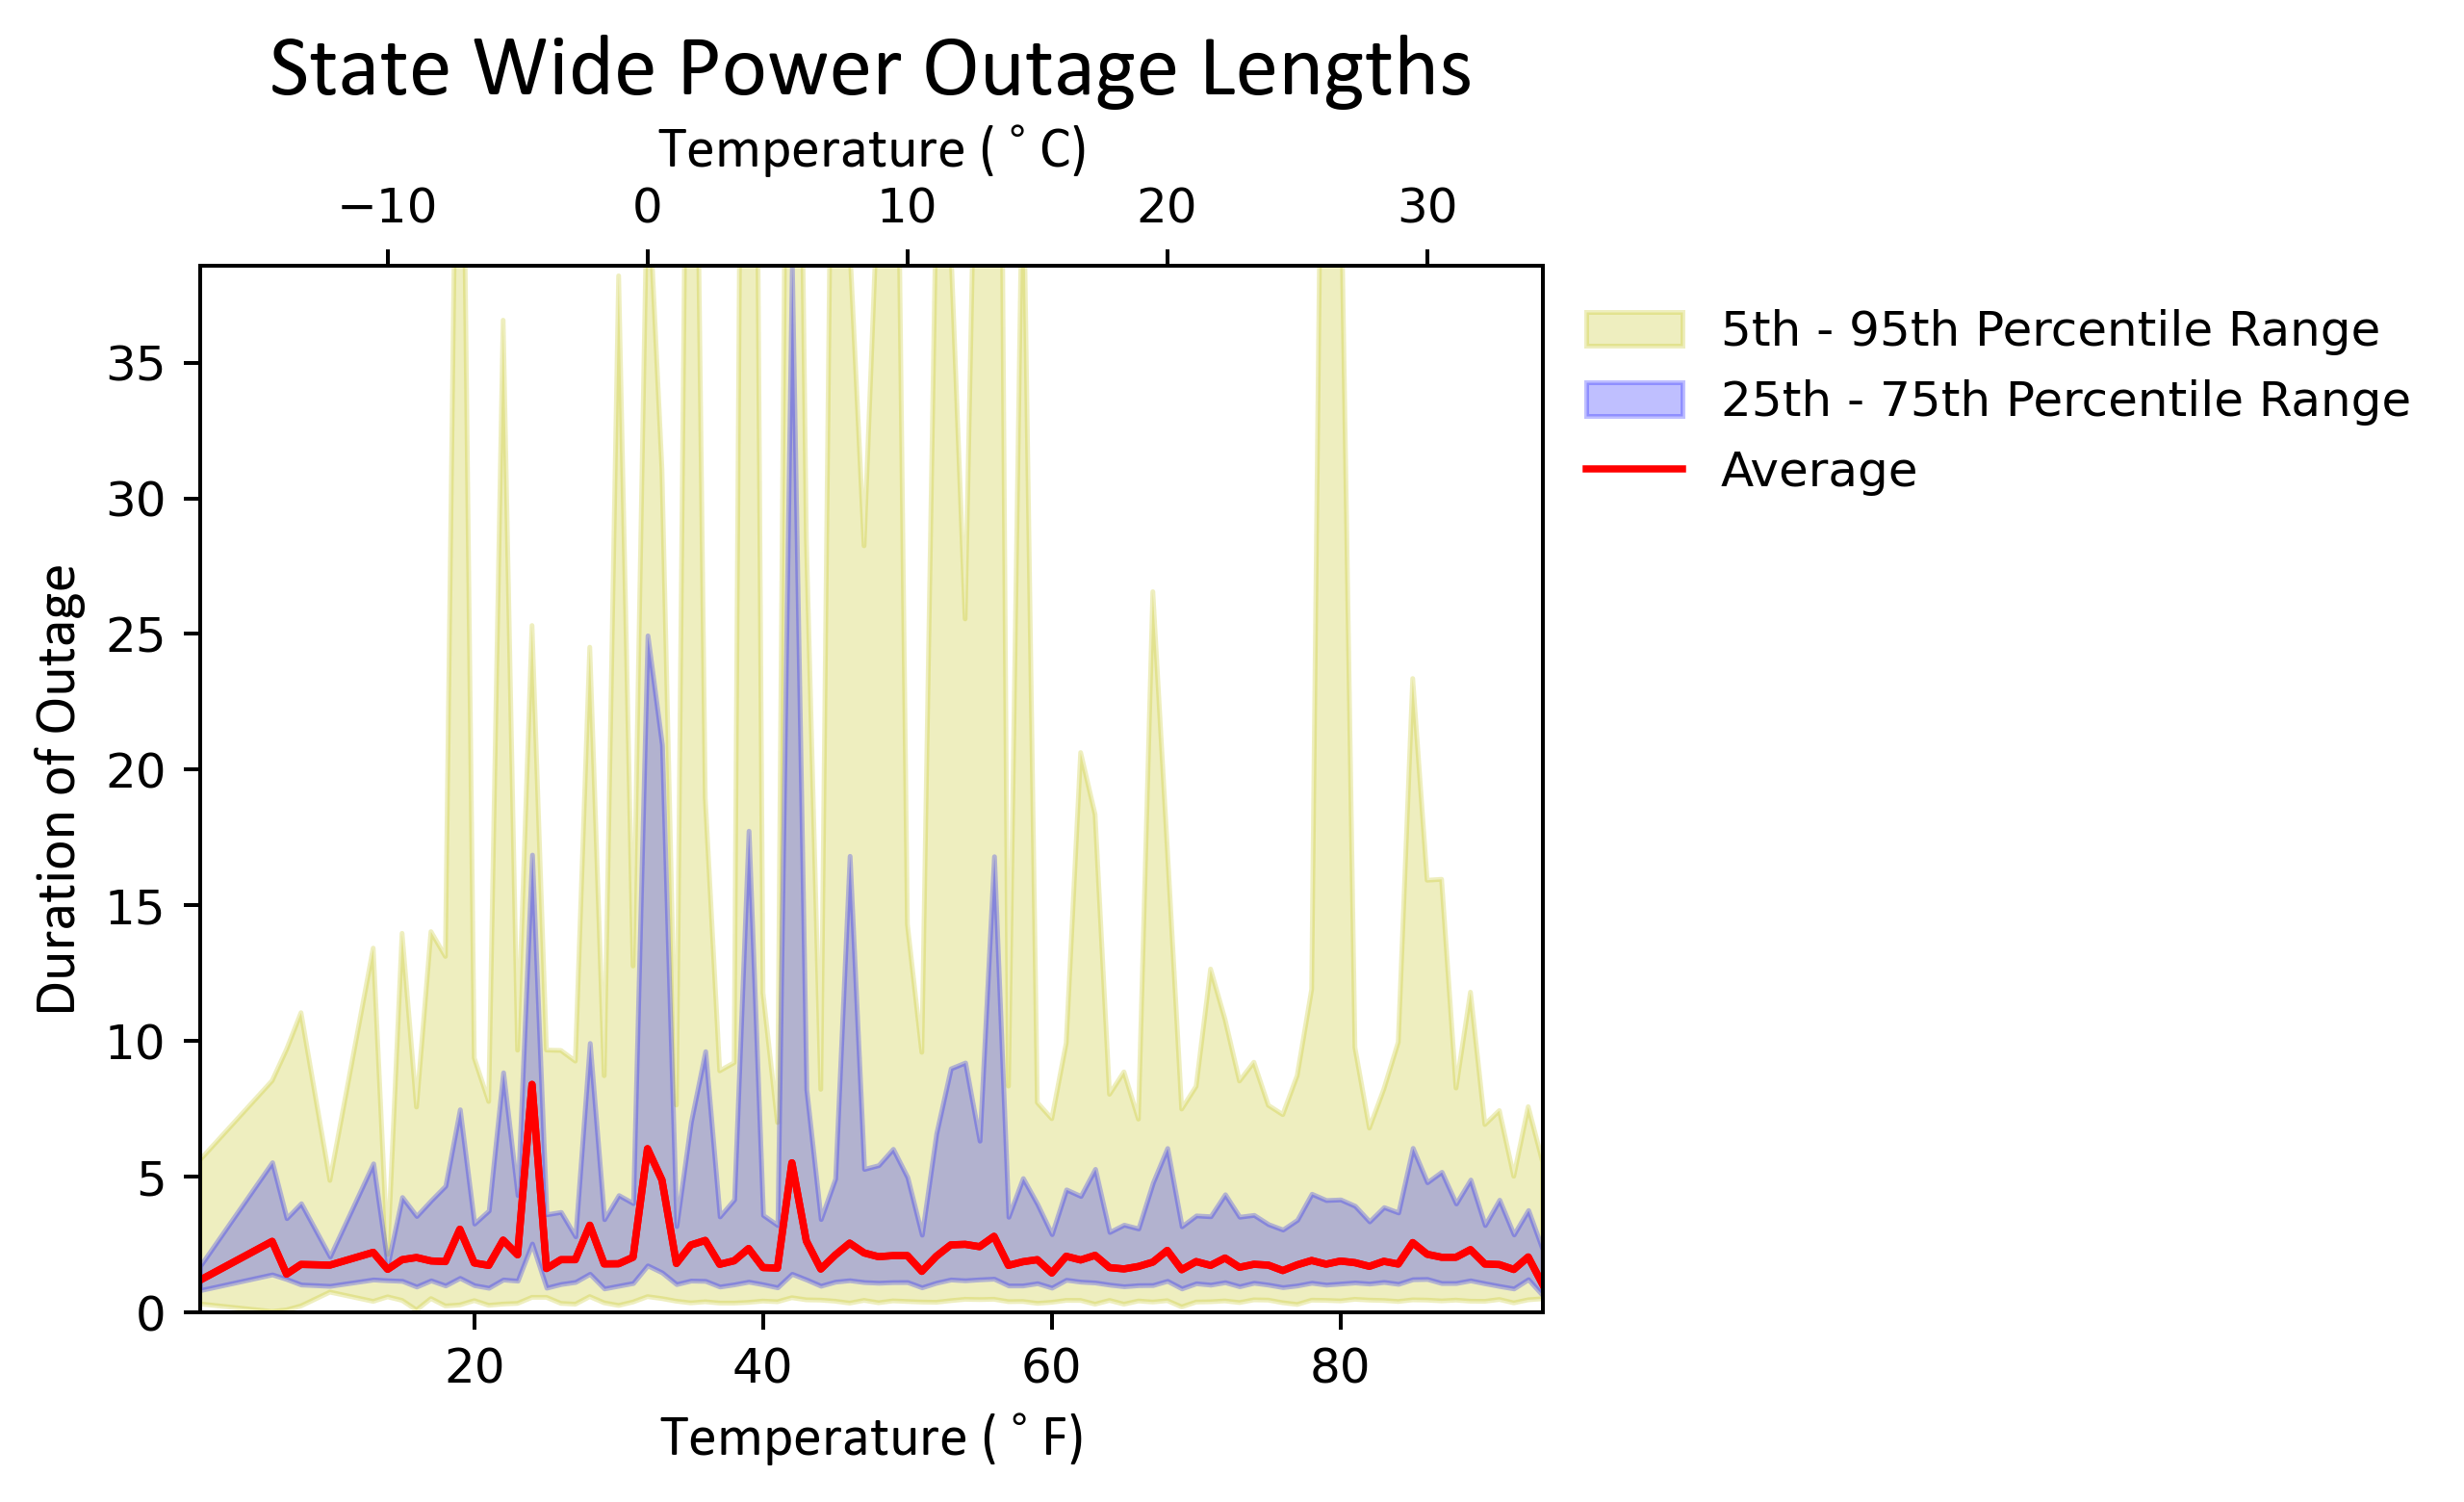

In [11]:
f1, ax1 = plt.subplots(figsize=(5,4),dpi=360)
ax1.fill_between(summary.index, summary['5%'], summary['95%'],alpha=.25,color='y',label="5th - 95th Percentile Range")
ax1.fill_between(summary.index, summary['25%'], summary['75%'],alpha=.25,color='b',label="25th - 75th Percentile Range")
ax1.plot(summary.index,summary['50%'],color='r',label="Average")
ax1.set_ylabel('Duration of Outage',fontsize=labelsize,**labelfont)
ax1.set_xlabel('Temperature ($^\circ$F)',fontsize=labelsize,**labelfont)
ax1b=ax1.twiny()
ax1b.plot(F_to_C(summary.index),summary['50%'],color='r',label="Average")
ax1b.set_xlabel('Temperature ($^\circ$C)',fontsize=labelsize,**labelfont)
ax1.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left',frameon=False)
ax1.set_xlim([min(summary.index),max(summary.index)])
ax1b.set_xlim([F_to_C(min(summary.index)),F_to_C(max(summary.index))])
ax1.set_ylim([min_D,max(summary['75%'])])
ax1.set_title('State Wide Power Outage Lengths',fontsize=titlesize,**labelfont)
f1.savefig(data_file_path + "/ERP/figures/"+"State_POL_Zoom_1.svg",bbox_inches = "tight")
f1.savefig(data_file_path + "/ERP/figures/"+"State_POL_Zoom_1.png",bbox_inches = "tight")

Text(0.5, 1.0, 'Histogram of Outage Start Time')

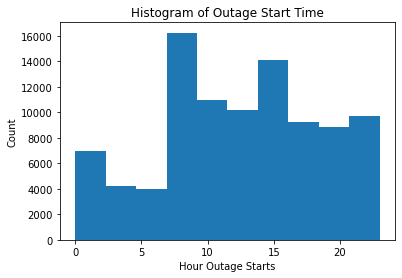

In [12]:
plt.hist(outages['Date and Time In'].dt.hour)
plt.ylabel('Count')
plt.xlabel('Hour Outage Starts')
plt.title('Histogram of Outage Start Time')

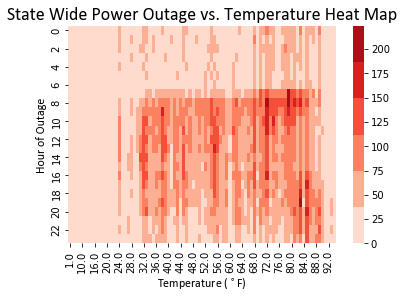

In [13]:
outages['Hour'] = outages['Date and Time In'].dt.hour

hours = outages['Hour'].unique()
temperatures = outages['TMAX'].unique()
data = pd.DataFrame()
data['Hour'] = 0
data['TMAX'] = 0
data['Count'] = 0
for each_hr in hours:
    for each_temp in temperatures: 
        count = len(outages.loc[(outages['Hour'] == each_hr) & (outages['TMAX']==each_temp)])
        counter = pd.DataFrame({'Hour': each_hr, 'TMAX': each_temp, 'Count': count}, index=[0])
        data = pd.concat([data,counter])
        
result = data.pivot(index='Hour',columns='TMAX',values='Count')
colormap = sns.color_palette("Reds")
 
ax = sns.heatmap(result,cmap=colormap)
ax.set_ylabel('Hour of Outage',fontsize=labelsize,**labelfont)
ax.set_xlabel('Temperature ($^\circ$F)',fontsize=labelsize,**labelfont)
ax.set_title('State Wide Power Outage vs. Temperature Heat Map',fontsize=titlesize,**labelfont)
plt.savefig(data_file_path + "/ERP/figures/"+"State_Heat_Map.svg",bbox_inches = "tight")
plt.savefig(data_file_path + "/ERP/figures/"+"State_Heat_Map.png",bbox_inches = "tight")

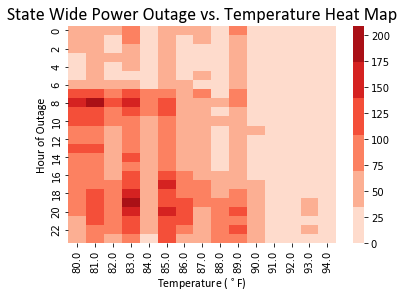

In [14]:
outages['Hour'] = outages['Date and Time In'].dt.hour

hours = outages['Hour'].unique()
temperatures = outages['TMAX'].unique()
data = pd.DataFrame()
data['Hour'] = 0
data['TMAX'] = 0
data['Count'] = 0
for each_hr in hours:
    for each_temp in temperatures: 
        if each_temp >= 80:
            count = len(outages.loc[(outages['Hour'] == each_hr) & (outages['TMAX']==each_temp)])
            counter = pd.DataFrame({'Hour': each_hr, 'TMAX': each_temp, 'Count': count}, index=[0])
            data = pd.concat([data,counter])
        
result = data.pivot(index='Hour',columns='TMAX',values='Count')
colormap = sns.color_palette("Reds")
 
ax = sns.heatmap(result,cmap=colormap)
ax.set_ylabel('Hour of Outage',fontsize=labelsize,**labelfont)
ax.set_xlabel('Temperature ($^\circ$F)',fontsize=labelsize,**labelfont)
ax.set_title('State Wide Power Outage vs. Temperature Heat Map',fontsize=titlesize,**labelfont)
plt.savefig(data_file_path + "/ERP/figures/"+"State_Heat_Map_Heat.svg",bbox_inches = "tight")
plt.savefig(data_file_path + "/ERP/figures/"+"State_Heat_Map_Heat.png",bbox_inches = "tight")

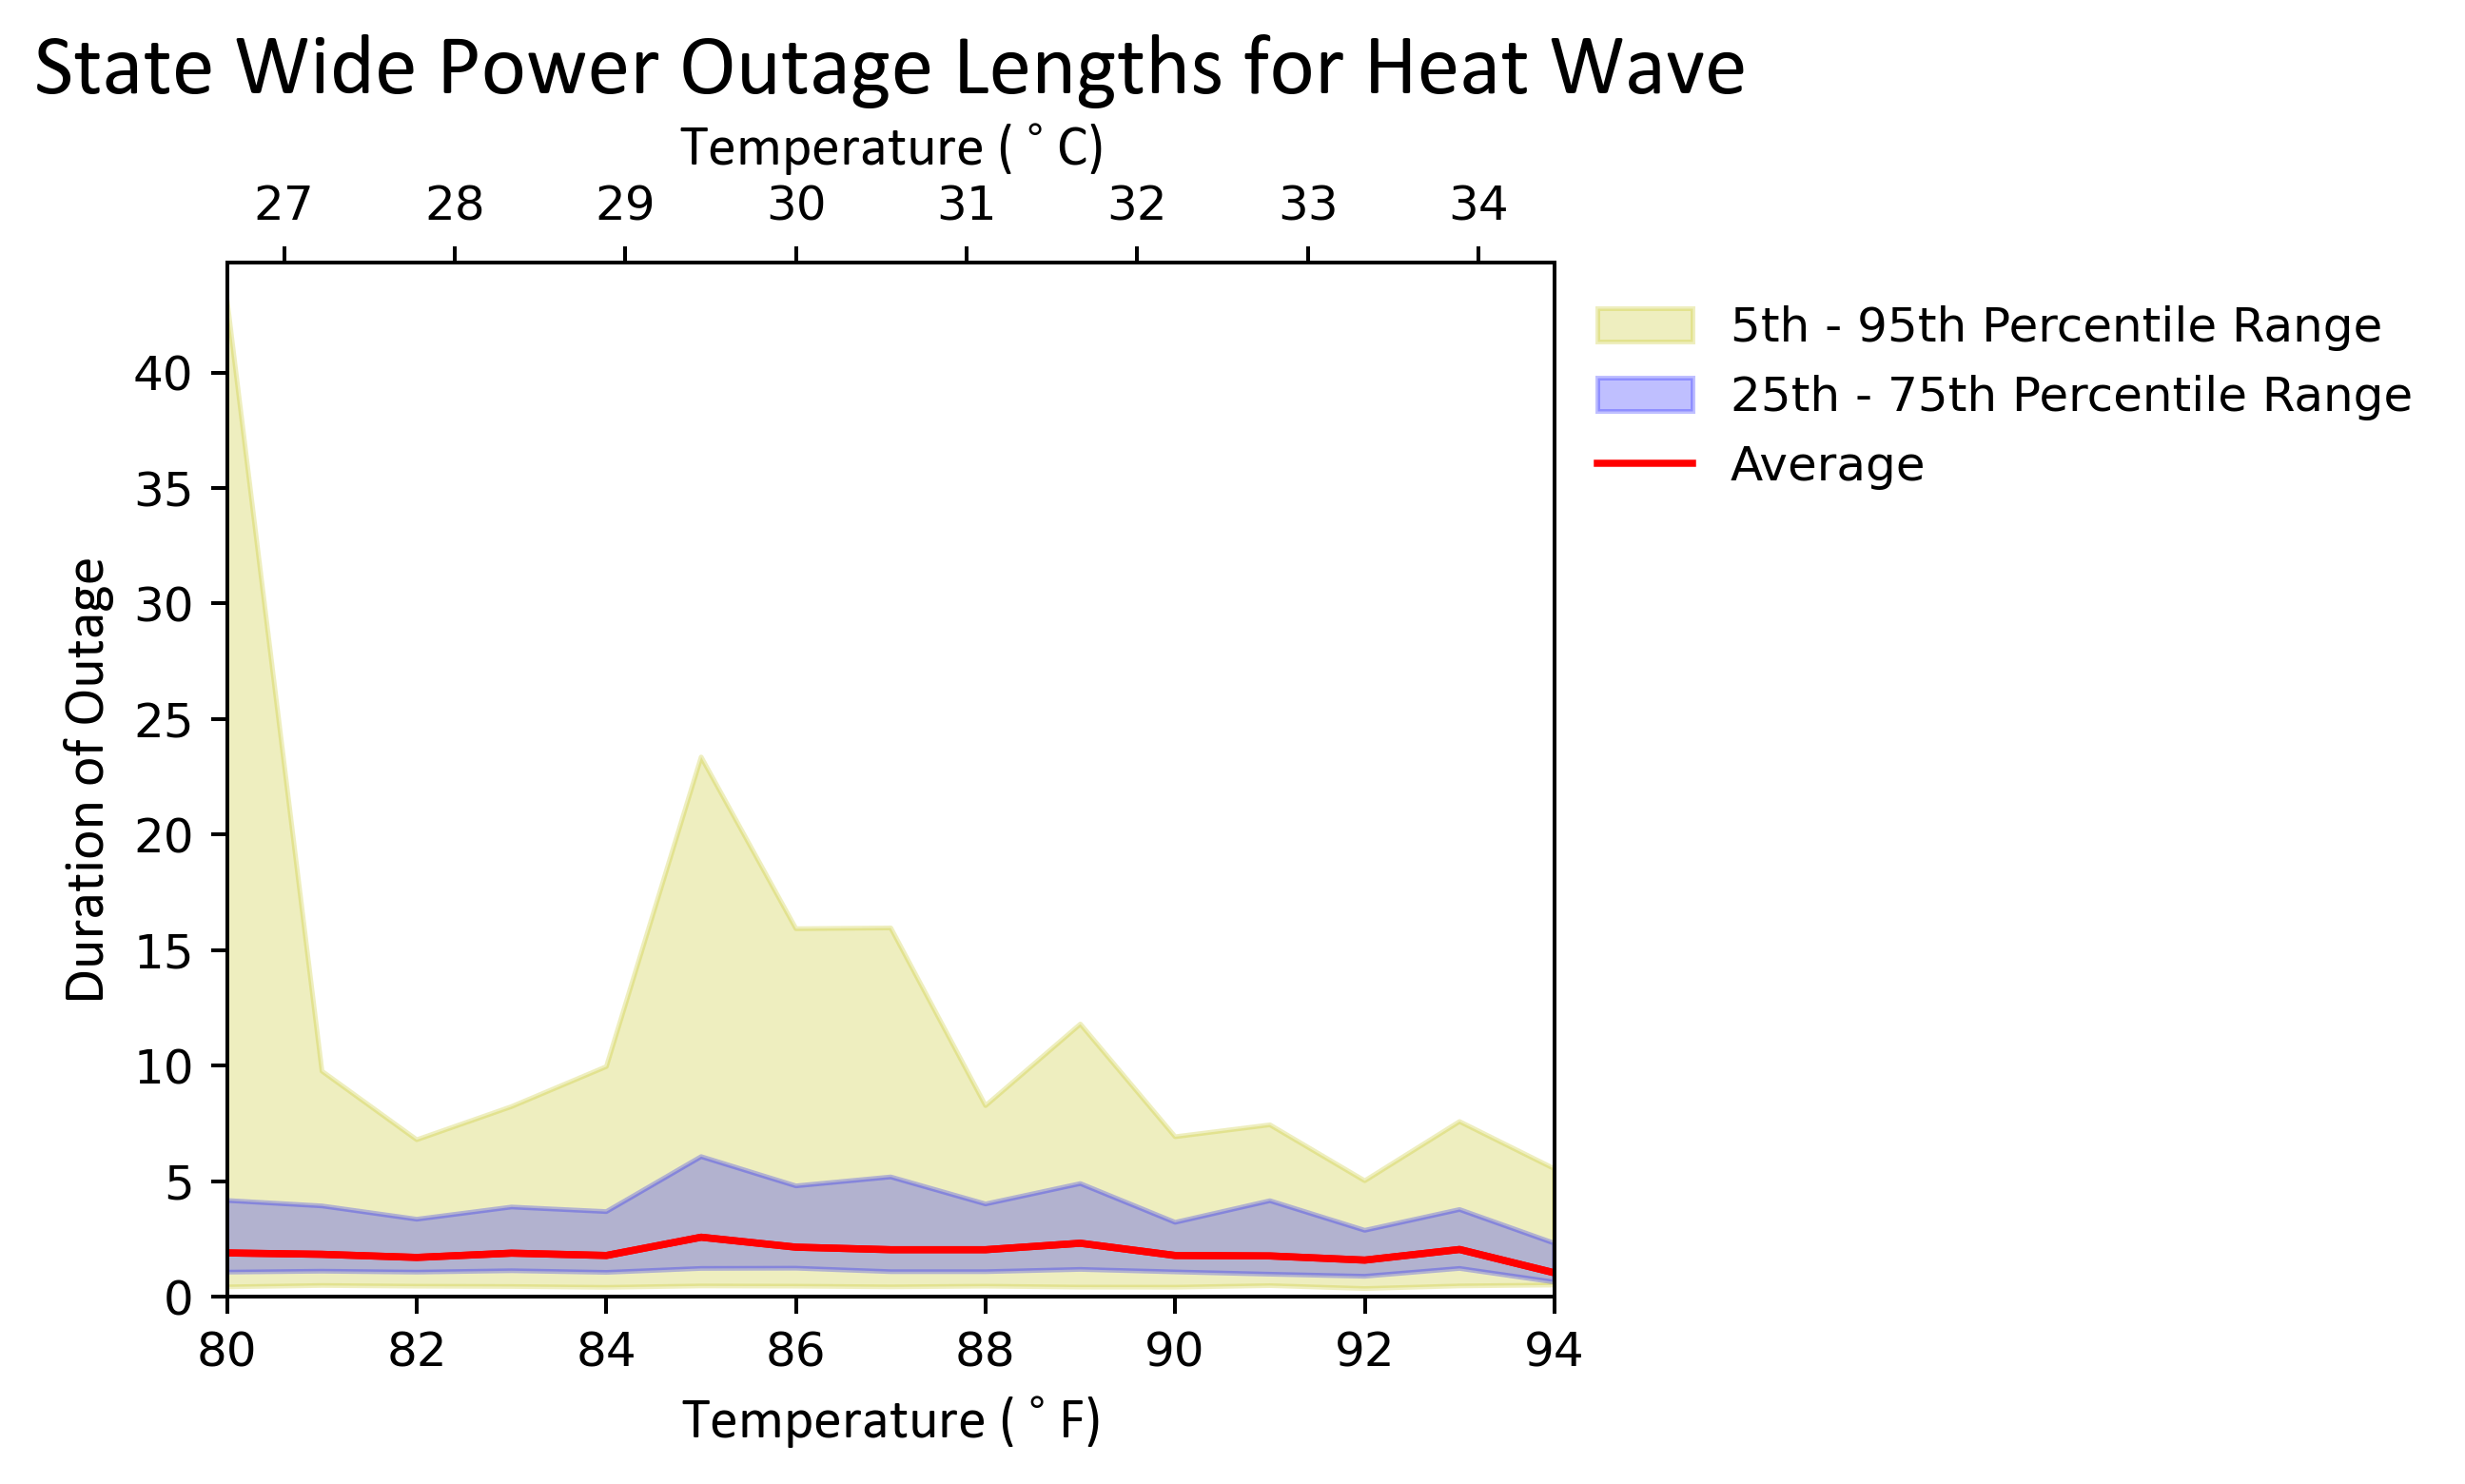

In [15]:
f1, ax1 = plt.subplots(figsize=(5,4),dpi=360)
ax1.fill_between(summary.index, summary['5%'], summary['95%'],alpha=.25,color='y',label="5th - 95th Percentile Range")
ax1.fill_between(summary.index, summary['25%'], summary['75%'],alpha=.25,color='b',label="25th - 75th Percentile Range")
ax1.plot(summary.index,summary['50%'],color='r',label="Average")
ax1.set_ylabel('Duration of Outage',fontsize=labelsize,**labelfont)
ax1.set_xlabel('Temperature ($^\circ$F)',fontsize=labelsize,**labelfont)
ax1b=ax1.twiny()
ax1b.plot(F_to_C(summary.index),summary['50%'],color='r',label="Average")
ax1b.set_xlabel('Temperature ($^\circ$C)',fontsize=labelsize,**labelfont)
ax1.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left',frameon=False)
ax1.set_xlim([hot_T,max(summary.index)])
ax1b.set_xlim([F_to_C(hot_T),F_to_C(max(summary.index))])
ax1.set_ylim([min_D,max(summary['95%'])/2])
ax1.set_title('State Wide Power Outage Lengths for Heat Wave',fontsize=titlesize,**labelfont)
f1.savefig(data_file_path + "/ERP/figures/"+"State_POL_Heat_Zoom_0.svg",bbox_inches = "tight")
f1.savefig(data_file_path + "/ERP/figures/"+"State_POL_Heat_Zoom_0.png",bbox_inches = "tight")

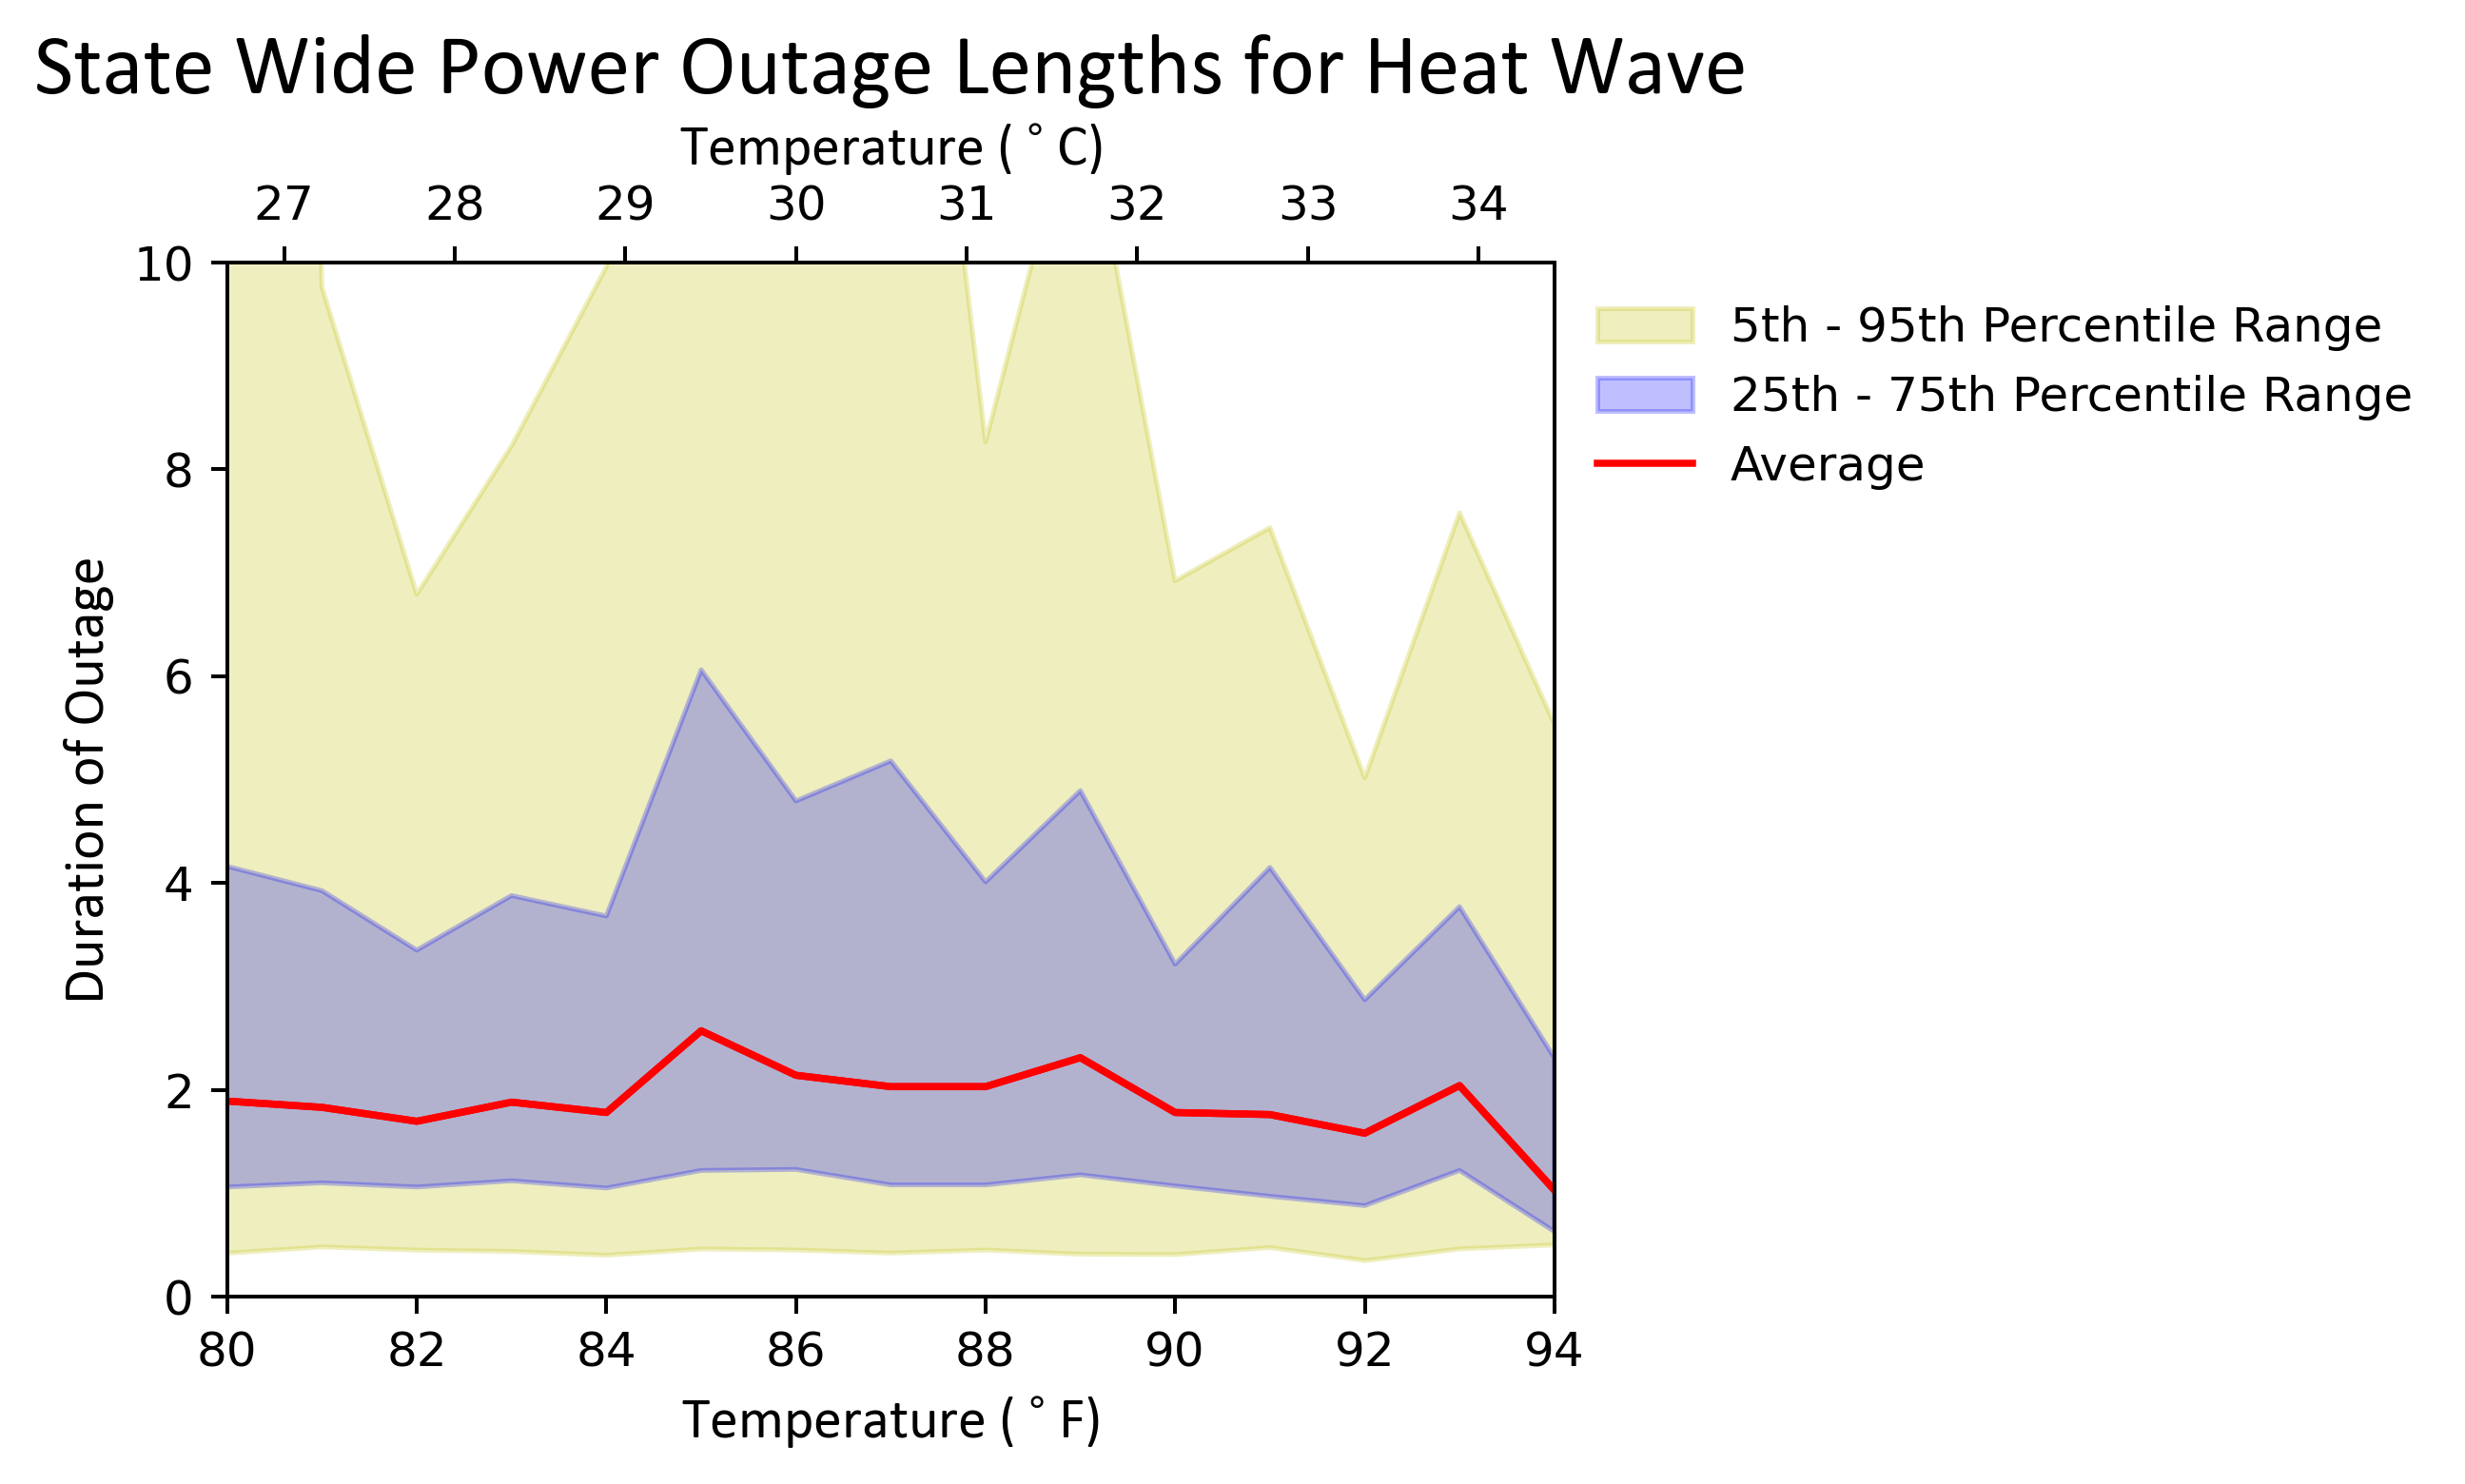

In [16]:
f1, ax1 = plt.subplots(figsize=(5,4),dpi=360)
ax1.fill_between(summary.index, summary['5%'], summary['95%'],alpha=.25,color='y',label="5th - 95th Percentile Range")
ax1.fill_between(summary.index, summary['25%'], summary['75%'],alpha=.25,color='b',label="25th - 75th Percentile Range")
ax1.plot(summary.index,summary['50%'],color='r',label="Average")
ax1.set_ylabel('Duration of Outage',fontsize=labelsize,**labelfont)
ax1.set_xlabel('Temperature ($^\circ$F)',fontsize=labelsize,**labelfont)
ax1b=ax1.twiny()
ax1b.plot(F_to_C(summary.index),summary['50%'],color='r',label="Average")
ax1b.set_xlabel('Temperature ($^\circ$C)',fontsize=labelsize,**labelfont)
ax1.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left',frameon=False)
ax1.set_xlim([hot_T,max(summary.index)])
ax1b.set_xlim([F_to_C(hot_T),F_to_C(max(summary.index))])
ax1.set_ylim([min_D,10])
ax1.set_title('State Wide Power Outage Lengths for Heat Wave',fontsize=titlesize,**labelfont)
f1.savefig(data_file_path + "/ERP/figures/"+"State_POL_Heat_Zoom_1.svg",bbox_inches = "tight")
f1.savefig(data_file_path + "/ERP/figures/"+"State_POL_Heat_Zoom_1.png",bbox_inches = "tight")

Text(0.5, 1.0, 'Histogram of Outage Start Time during Extreme Heat')

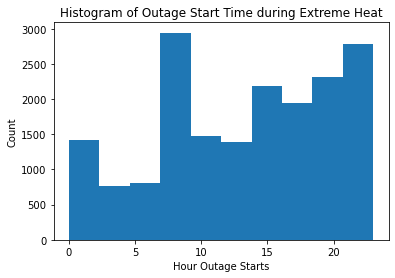

In [17]:
heat_waves = outages.loc[outages['TMAX'] >= 80]
plt.hist(heat_waves['Date and Time In'].dt.hour)
plt.ylabel('Count')
plt.xlabel('Hour Outage Starts')
plt.title('Histogram of Outage Start Time during Extreme Heat')

In [18]:
worcester_outages = outages.loc[outages['City/Town'] == 'WORCESTER']
worcester_outages = worcester_outages.reset_index(drop = True)

In [19]:
summary = pd.DataFrame()
summary.index = worcester_outages['TMAX'].unique()
summary['5%'] = 0 
summary['25%'] = 0 
summary['50%'] = 0 
summary['75%'] = 0 
summary['95%'] = 0 

for each_t in summary.index:
    sample = worcester_outages.loc[worcester_outages['TMAX'] == each_t]
      summary.loc[summary.index == each_t,'5%'] = sample['Actual Duration'].quantile(q=.05)
    summary.loc[summary.index == each_t,'25%'] = sample['Actual Duration'].quantile(q=.25)
    summary.loc[summary.index == each_t,'50%'] = sample['Actual Duration'].quantile(q=.5)
    summary.loc[summary.index == each_t,'75%'] = sample['Actual Duration'].quantile(q=.75)
    summary.loc[summary.index == each_t,'95%'] = sample['Actual Duration'].quantile(q=.95)
summary = summary.dropna()
summary = summary.sort_index()


IndentationError: unexpected indent (3477444554.py, line 11)

In [ ]:
f1, ax1 = plt.subplots(figsize=(5,4),dpi=360)
ax1.fill_between(summary.index, summary['5%'], summary['95%'],alpha=.25,color='y',label="5th - 95th Percentile Range")
ax1.fill_between(summary.index, summary['25%'], summary['75%'],alpha=.25,color='b',label="25th - 75th Percentile Range")
ax1.plot(summary.index,summary['50%'],color='r',label="Average")
ax1.set_ylabel('Duration of Outage',fontsize=labelsize,**labelfont)
ax1.set_xlabel('Temperature ($^\circ$F)',fontsize=labelsize,**labelfont)
ax1b=ax1.twiny()
ax1b.plot(F_to_C(summary.index),summary['50%'],color='r',label="Average")
ax1b.set_xlabel('Temperature ($^\circ$C)',fontsize=labelsize,**labelfont)
ax1.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left',frameon=False)
ax1.set_xlim([min(summary.index),max(summary.index)])
ax1b.set_xlim([F_to_C(min(summary.index)),F_to_C(max(summary.index))])
ax1.set_ylim([min_D,max(summary['95%'])])
ax1.set_title('Worcester Wide Power Outage Lengths',fontsize=titlesize,**labelfont)
f1.savefig(data_file_path + "/ERP/figures/"+"Worcester_POL_Zoom_0.svg",bbox_inches = "tight")
f1.savefig(data_file_path + "/ERP/figures/"+"Worcester_POL_Zoom_0.png",bbox_inches = "tight")

In [ ]:
f1, ax1 = plt.subplots(figsize=(5,4),dpi=360)
ax1.fill_between(summary.index, summary['5%'], summary['95%'],alpha=.25,color='y',label="5th - 95th Percentile Range")
ax1.fill_between(summary.index, summary['25%'], summary['75%'],alpha=.25,color='b',label="25th - 75th Percentile Range")
ax1.plot(summary.index,summary['50%'],color='r',label="Average")
ax1.set_ylabel('Duration of Outage',fontsize=labelsize,**labelfont)
ax1.set_xlabel('Temperature ($^\circ$F)',fontsize=labelsize,**labelfont)
ax1b=ax1.twiny()
ax1b.plot(F_to_C(summary.index),summary['50%'],color='r',label="Average")
ax1b.set_xlabel('Temperature ($^\circ$C)',fontsize=labelsize,**labelfont)
ax1.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left',frameon=False)
ax1.set_xlim([min(summary.index),max(summary.index)])
ax1b.set_xlim([F_to_C(min(summary.index)),F_to_C(max(summary.index))])
ax1.set_ylim([min_D,max(summary['75%'])])
ax1.set_title('Worcester Power Outage Lengths',fontsize=titlesize,**labelfont)
f1.savefig(data_file_path + "/ERP/figures/"+"Worcester_POL_Zoom_1.svg",bbox_inches = "tight")
f1.savefig(data_file_path + "/ERP/figures/"+"Worcester_POL_Zoom_1.png",bbox_inches = "tight")

In [ ]:
plt.hist(worcester_outages['Date and Time In'].dt.hour)
plt.ylabel('Count')
plt.xlabel('Hour Outage Starts')
plt.title('Histogram of Worcester Outage Start Time')

In [ ]:
worcester_outages['Hour'] = worcester_outages['Date and Time In'].dt.hour
hours = worcester_outages['Hour'].unique()
temperatures = worcester_outages['TMAX'].unique()
data = pd.DataFrame()
data['Hour'] = 0
data['TMAX'] = 0
data['Count'] = 0
for each_hr in hours:
    for each_temp in temperatures: 
        count = len(worcester_outages.loc[(worcester_outages['Hour'] == each_hr) & (worcester_outages['TMAX']==each_temp)])
        counter = pd.DataFrame({'Hour': each_hr, 'TMAX': each_temp, 'Count': count}, index=[0])
        data = pd.concat([data,counter])
        
result = data.pivot(index='Hour',columns='TMAX',values='Count')
colormap = sns.color_palette("Reds")
 
sns.heatmap(result,cmap=colormap)
ax = sns.heatmap(result,cmap=colormap)
ax.set_ylabel('Hour of Outage',fontsize=labelsize,**labelfont)
ax.set_xlabel('Temperature ($^\circ$F)',fontsize=labelsize,**labelfont)
ax.set_title('Worcester Wide Power Outage vs. Temperature Heat Map',fontsize=titlesize,**labelfont)
plt.savefig(data_file_path + "/ERP/figures/"+"Worcester_Heat_Map.svg",bbox_inches = "tight")
plt.savefig(data_file_path + "/ERP/figures/"+"Worcester_Heat_Map.png",bbox_inches = "tight")

In [ ]:
worcester_outages['Hour'] = worcester_outages['Date and Time In'].dt.hour
hours = worcester_outages['Hour'].unique()
temperatures = worcester_outages['TMAX'].unique()
data = pd.DataFrame()
data['Hour'] = 0
data['TMAX'] = 0
data['Count'] = 0
for each_hr in hours:
    for each_temp in temperatures: 
        if each_temp >= 80:
            count = len(worcester_outages.loc[(worcester_outages['Hour'] == each_hr) & (worcester_outages['TMAX']==each_temp)])
            counter = pd.DataFrame({'Hour': each_hr, 'TMAX': each_temp, 'Count': count}, index=[0])
            data = pd.concat([data,counter])

result = data.pivot(index='Hour',columns='TMAX',values='Count')
colormap = sns.color_palette("Reds")
 
ax = sns.heatmap(result,cmap=colormap)
ax.set_ylabel('Hour of Outage',fontsize=labelsize,**labelfont)
ax.set_xlabel('Temperature ($^\circ$F)',fontsize=labelsize,**labelfont)
ax.set_title('Worcester Wide Power Outage vs. Temperature Heat Map',fontsize=titlesize,**labelfont)
plt.savefig(data_file_path + "/ERP/figures/"+"Worcester_Heat_Map_Heat.svg",bbox_inches = "tight")
plt.savefig(data_file_path + "/ERP/figures/"+"Worcester_Heat_Map_Heat.png",bbox_inches = "tight")

In [ ]:
f1, ax1 = plt.subplots(figsize=(5,4),dpi=360)
ax1.fill_between(summary.index, summary['5%'], summary['95%'],alpha=.25,color='y',label="5th - 95th Percentile Range")
ax1.fill_between(summary.index, summary['25%'], summary['75%'],alpha=.25,color='b',label="25th - 75th Percentile Range")
ax1.plot(summary.index,summary['50%'],color='r',label="Average")
ax1.set_ylabel('Duration of Outage',fontsize=labelsize,**labelfont)
ax1.set_xlabel('Temperature ($^\circ$F)',fontsize=labelsize,**labelfont)
ax1b=ax1.twiny()
ax1b.plot(F_to_C(summary.index),summary['50%'],color='r',label="Average")
ax1b.set_xlabel('Temperature ($^\circ$C)',fontsize=labelsize,**labelfont)
ax1.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left',frameon=False)
ax1.set_xlim([hot_T,max(summary.index)])
ax1b.set_xlim([F_to_C(hot_T),F_to_C(max(summary.index))])
ax1.set_ylim([min_D,40])
ax1.set_title('Worcester Wide Power Outage Lengths',fontsize=titlesize,**labelfont)
f1.savefig(data_file_path + "/ERP/figures/"+"Worcester_POL_Heat_Zoom_0.svg",bbox_inches = "tight")
f1.savefig(data_file_path + "/ERP/figures/"+"Worcester_POL_Heat_Zoom_0.png",bbox_inches = "tight")

In [ ]:
f1, ax1 = plt.subplots(figsize=(5,4),dpi=360)
ax1.fill_between(summary.index, summary['5%'], summary['95%'],alpha=.25,color='y',label="5th - 95th Percentile Range")
ax1.fill_between(summary.index, summary['25%'], summary['75%'],alpha=.25,color='b',label="25th - 75th Percentile Range")
ax1.plot(summary.index,summary['50%'],color='r',label="Average")
ax1.set_ylabel('Duration of Outage',fontsize=labelsize,**labelfont)
ax1.set_xlabel('Temperature ($^\circ$F)',fontsize=labelsize,**labelfont)
ax1b=ax1.twiny()
ax1b.plot(F_to_C(summary.index),summary['50%'],color='r',label="Average")
ax1b.set_xlabel('Temperature ($^\circ$C)',fontsize=labelsize,**labelfont)
ax1.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left',frameon=False)
ax1.set_xlim([hot_T,max(summary.index)])
ax1b.set_xlim([F_to_C(hot_T),F_to_C(max(summary.index))])
ax1.set_ylim([min_D,15])
ax1.set_title('Worcester Wide Power Outage Lengths',fontsize=titlesize,**labelfont)
f1.savefig(data_file_path + "/ERP/figures/"+"Worcester_POL_Heat_Zoom_1.svg",bbox_inches = "tight")
f1.savefig(data_file_path + "/ERP/figures/"+"Worcester_POL_Heat_Zoom_1.png",bbox_inches = "tight")

In [ ]:
worcester_heat_waves = worcester_outages.loc[outages['TMAX'] >= 80]

plt.hist(worcester_heat_waves['Date and Time In'].dt.hour)
plt.ylabel('Count')
plt.xlabel('Hour Outage Starts')
plt.title('Histogram of Worcester Outage Start Time During Extreme Heat')

In [ ]:
plt.scatter(worcester_heat_waves['TMAX'],worcester_heat_waves['Date and Time In'].dt.hour)

In [ ]:
heat_waves['Hour'] = heat_waves['Date and Time In'].dt.hour
hours = heat_waves['Hour'].unique()
temperatures = heat_waves['TMAX'].unique()
data = pd.DataFrame()
data['Hour'] = 0
data['TMAX'] = 0
data['Count'] = 0
for each_hr in hours:
    for each_temp in temperatures: 
        count = len(heat_waves.loc[(heat_waves['Hour'] == each_hr) & (heat_waves['TMAX']==each_temp)])
        counter = pd.DataFrame({'Hour': each_hr, 'TMAX': each_temp, 'Count': count}, index=[0])
        data = pd.concat([data,counter])
        
result = data.pivot(index='Hour',columns='TMAX',values='Count')
colormap = sns.color_palette("Reds")
 
sns.heatmap(result,cmap=colormap)

In [ ]:
worcester_heat_waves['Hour'] = worcester_heat_waves['Date and Time In'].dt.hour
hours = worcester_heat_waves['Hour'].unique()
temperatures = worcester_heat_waves['TMAX'].unique()
data = pd.DataFrame()
data['Hour'] = 0
data['TMAX'] = 0
data['Count'] = 0
for each_hr in hours:
    for each_temp in temperatures: 
        count = len(worcester_heat_waves.loc[(worcester_heat_waves['Hour'] == each_hr) & (worcester_heat_waves['TMAX']==each_temp)])
        counter = pd.DataFrame({'Hour': each_hr, 'TMAX': each_temp, 'Count': count}, index=[0])
        data = pd.concat([data,counter])
        
result = data.pivot(index='Hour',columns='TMAX',values='Count')
colormap = sns.color_palette("Reds")
 
sns.heatmap(result,cmap=colormap)

In [ ]:
print(F_to_C(3))